## Deep Learning in Computer Vision

Topics Covered:

    1. 
    2. 
    3. 
    4. 
    5. 

In [195]:
# Necessary Imports
import torch, torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Challenges of using Linear Layers/FCN Layers?

* Loss of Spatial Information.
    * Flattening an image into 1D array loses all the spatial information about the image.
* High complexity (number of weights for all layers in FCN)

### Building an Image Classifier on MNIST Dataset

Steps:

1. Getting the Data
2. Pre-process (flattening, resizing -- if required, split the dataset - train_test_split)
3. Build model (CNN)
4. Train and Validate the model.
5. Test on Unseen Data (Test Dataset)

**Step-1: Getting the Data**

```python
help(torchvision.datasets)
```
Output:
```
Help on package torchvision.datasets in torchvision:

NAME
    torchvision.datasets

PACKAGE CONTENTS
    cifar
    coco
    fakedata
    folder
    lsun
    mnist
    omniglot
    phototour
    semeion
    stl10
    svhn
    utils
```

It's clear that we have mnist dataset available in torchvision datasets utility class. Let's go ahead and import mnist dataset.

In [5]:
import torchvision.datasets.mnist as mnist

In [9]:
# required transformations
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), \
                                                                                (0.3081, ))])

In [11]:
train_dataset = mnist.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = mnist.MNIST('data/', train=False, transform=transformation, download=True)

Processing...
Done!


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [36]:
# utility function to convert a tensor into an image
def show_image(tensor, cmap=None):
    image = tensor.numpy()[0]
    mean = 0.1307
    std_dev = 0.3081
    image = ((mean * image) + std_dev)
    plt.imshow(image, cmap) # show gray-scaled version of the image
    plt.show()

In [29]:
next(iter(train_loader))[0] # returns batch of 32 images, randomly

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

Showing image in color mode


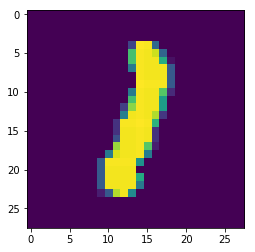

Showing image in grayscale mode


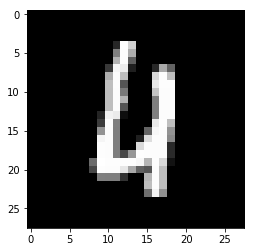

In [39]:
print("Showing image in color mode")
show_image(next(iter(train_loader))[0][0])
print("Showing image in grayscale mode")
show_image(next(iter(train_loader))[0][0], cmap='gray')

## Building Model

Generally, a CNN is composed of following layers:

1. Conv2d
2. MaxPooling2d
3. ReLU
4. View
5. Linear Layer (FC Layer)
6. Dropout

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2d_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.max_pool2d(self.conv2d_dropout(self.conv2(x)), 2)
        x = x.view(-1, 320) # why?
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## How does Convolution works in PyTorch?

Take an example of a 1D array. Let's try to apply a conv filter on the array.

```
conv = nn.Conv1d(1, 1, 3, bias=False)
```

Let's look at the docs of `nn.Conv1d`:

```docs
class Conv1d(_ConvNd)
 |  Applies a 1D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  (N, C_{in}, L) and output (N, C_{out}, L_{out}) can be
 |  precisely described as:
```
$$
\begin{equation*}
\text{out}(N_i, C_{out_j}) = \text{bias}(C_{out_j}) + \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{out_j}, k) \star \text{input}(N_i, k)
\end{equation*}
$$

```docs
 |  Attributes:
 |      weight (Tensor): the learnable weights of the module of shape
 |          (out_channels, in_channels, kernel_size)
 |      bias (Tensor):   the learnable bias of the module of shape
 |          (out_channels)
 |  
 |  Examples::
 |  
 |      >>> m = nn.Conv1d(16, 33, 3, stride=2)
 |      >>> input = torch.randn(20, 16, 50)
 |      >>> output = m(input)
```

In [76]:
net = nn.Conv1d(16, 33, 3, stride=2)
print("Net.weight: ", net.weight[0][0])
print("Net bias: ", net.bias[0][0])
input_ = torch.randn(20, 16, 50)
print("Shape of input tensor: {}".format(input_.shape))
output = net(input_)
print("Input", input_[0][0])
print("output", output[0][0])

Net.weight:  tensor([ 0.0898, -0.0290, -0.0184], grad_fn=<SelectBackward>)
Net bias:  tensor(-0.0234, grad_fn=<AliasBackward>)
Shape of input tensor: torch.Size([20, 16, 50])
Input tensor([ 0.4412,  1.1871,  1.2538,  0.9038, -0.4481,  1.3991, -0.9111,  0.2678,
         1.1055,  1.9549, -1.1615, -1.0567,  0.5989,  0.1253,  0.7138,  1.2872,
         1.2061, -0.4276, -1.0316, -2.1270,  0.6886,  0.5826, -1.3476,  0.6016,
        -0.3757, -1.1891,  0.6825, -0.0293, -1.0270,  0.8466,  1.6183, -1.1577,
        -1.6786,  1.4142, -0.6939, -0.8775, -1.0439,  0.1629,  1.2870, -1.2488,
        -0.8653,  0.8719,  0.2489, -2.0293, -2.2702,  0.8735,  0.9727,  0.5769,
        -0.4099, -0.9260])
output tensor([-0.4045,  0.4693, -0.6951, -0.4687, -0.0146, -0.4754,  0.5161, -0.1440,
        -0.2339, -0.2184,  0.3562, -0.5512, -0.7846, -0.8485, -0.1358,  0.3537,
        -0.2544,  0.1960, -0.3285,  0.1912, -0.1416,  0.0757,  0.1543,  1.5208],
       grad_fn=<SelectBackward>)


/home/kushashwa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
net.weight[0][0]

tensor([-0.0673,  0.1119, -0.0590], grad_fn=<SelectBackward>)

In [79]:
net.weight[0][0]

tensor([ 0.0898, -0.0290, -0.0184], grad_fn=<SelectBackward>)

In [91]:
net.bias[0]

tensor(-0.0234, grad_fn=<SelectBackward>)

In [88]:
print(input_[0][0][:3] * net.weight[0][0])
print("input_, net.weight, net.bias: {}/{}/{}".format(input_[0][0][:3], net.weight[0][0], net.bias[0][0]))

tensor([ 0.0396, -0.0344, -0.0231], grad_fn=<ThMulBackward>)
input_, net.weight, net.bias: tensor([0.4412, 1.1871, 1.2538])/tensor([ 0.0898, -0.0290, -0.0184], grad_fn=<SelectBackward>)/-0.023443467915058136


/home/kushashwa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


In [104]:
np.dot(input_[0][0][:3].detach().numpy(), net.weight[0][0].detach().numpy()) + net.bias[0].detach().numpy()

-0.041310795

In [98]:
type(net.weight)

torch.nn.parameter.Parameter

## Why Pooling?

Used just after a convolution layer, to reduce the data size to process. Also helps in reducing the size of feature maps. Also, forces algorithm to not focus on small changes in position. **(how?)**



## Why View? 

Generally, we use `torch.Tensor.view()` (https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) function at the end of a network, because for FC (Fully Connected) or Linear layers, we need to flatten the data to 1D.

While flattening, it's important to make sure that two different images don't mix-up. That's why we input the first argument to `torch.Tensor.view()` as `-1`.

Let's look at the docs of this function.

In [166]:
print(help(torch.Tensor.view))

Help on method_descriptor:

view(...)
    view(*args) -> Tensor
    
    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different size.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = 0, \dots, k-1`,
    
    .. math::
    
      stride[i] = stride[i+1] \times size[i+1]
    
    Otherwise, :func:`contiguous` needs to be called before the tensor can be
    viewed.
    
    Args:
        args (torch.Size or int...): the desired size
    
    Example::
    
        >>> x = torch.randn(4, 4)
        >>> x.size()
        torch.Size([4, 4])
     

In [164]:
torch.Tensor.view?

In [158]:
x = np.array([[[[8], [9]], [[2], [0.3]]], [[[8], [9]], [[2], [0.3]]]])
x = x.reshape((2, 1, 2, 2)) # reshape to (2, 1, 2, 2) - like a batch of 2 images of size (2x2) with 1 channel

In [159]:
x.view() # view the array x

array([[[[8. , 9. ],
         [2. , 0.3]]],


       [[[8. , 9. ],
         [2. , 0.3]]]])

In [160]:
x_tensor = torch.from_numpy(x) # conversion of numpy array to a pytorch tensor
# reference: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#converting-numpy-array-to-torch-tensor

In [161]:
print(x_tensor.shape) # verifying

torch.Size([2, 1, 2, 2])


In [167]:
x_tensor.view(-1, 4) 
# -1 means: don't touch the first dimension (only if the second dimension satisfies the total elements)
# if doesn't satisfy, then -1 is inferred from other dimensions

tensor([[8.0000, 9.0000, 2.0000, 0.3000],
        [8.0000, 9.0000, 2.0000, 0.3000]], dtype=torch.float64)

In [171]:
x_tensor.view(-1, 2) # example: this should return (4, 2) tensor

tensor([[8.0000, 9.0000],
        [2.0000, 0.3000],
        [8.0000, 9.0000],
        [2.0000, 0.3000]], dtype=torch.float64)

In [174]:
x_tensor.view(-1, 1) # example: this should return (8, 1) tensor

tensor([[8.0000],
        [9.0000],
        [2.0000],
        [0.3000],
        [8.0000],
        [9.0000],
        [2.0000],
        [0.3000]], dtype=torch.float64)

## Training the Model

In [197]:
def fit(epoch, optimizer, model, data_loader, volatile=False, phase='training'):
    if(phase == 'training'):
        model.train()
    if(phase == 'evaluation'):
        model.evaluate()
        volatile=True #why?
    
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
#         print(data)
#         if data.is_cuda():
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output, target, size_average=False).data[0]
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print("Loss: {}, accuracy: {}".format(loss, accuracy))
    return loss, accuracy

In [198]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [199]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)

In [200]:
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

In [204]:
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, optimizer, model, train_loader, volatile=False, phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,optimizer, model, test_loader, volatile=False, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/kushashwa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/kushashwa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss: 0.1206219345331192, accuracy: 96
Loss: 0.12402940541505814, accuracy: 96
Loss: 0.11611782014369965, accuracy: 96
Loss: 0.11210104078054428, accuracy: 96
Loss: 0.11929728090763092, accuracy: 96
Loss: 0.1225995272397995, accuracy: 96
Loss: 0.11394266784191132, accuracy: 96
Loss: 0.11298033595085144, accuracy: 96
Loss: 0.11729313433170319, accuracy: 96
Loss: 0.11354488879442215, accuracy: 96
Loss: 0.115715891122818, accuracy: 96
Loss: 0.11816882342100143, accuracy: 96
Loss: 0.11266960203647614, accuracy: 96
Loss: 0.11292938143014908, accuracy: 96
Loss: 0.11479900777339935, accuracy: 96
Loss: 0.12624315917491913, accuracy: 96
Loss: 0.11431062966585159, accuracy: 96
Loss: 0.1180247887969017, accuracy: 96
Loss: 0.1105051189661026, accuracy: 96
Loss: 0.12324003875255585, accuracy: 96
Loss: 0.11057820171117783, accuracy: 96
Loss: 0.10865706950426102, accuracy: 97
Loss: 0.10824849456548691, accuracy: 96
Loss: 0.11275696009397507, accuracy: 96
Loss: 0.10923698544502258, accuracy: 96
Loss: 

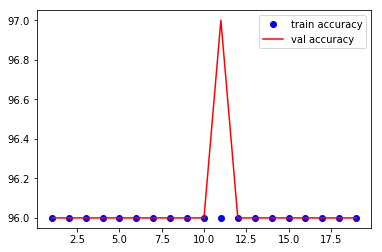

In [205]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()